In [1]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read in transcript data.

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)

# Create the spot sizes.

In [3]:
x_min, x_max = min(df_transcripts["x_location"]), max(df_transcripts["x_location"])
y_min, y_max = min(df_transcripts["y_location"]), max(df_transcripts["y_location"])
z_min, z_max = min(df_transcripts["z_location"]), max(df_transcripts["z_location"])

In [4]:
print(x_min, x_max)
print(y_min, y_max)
print(z_min, z_max)

2.532999 10305.357
5.974726 8793.226
6.964243 40.513294


In [5]:
plt.scatter(df_transcripts["x_location"], df_transcripts["y_location"], s=0.01)

In [5]:
SPOT_SIZE = 100
MIN_PAD = 1e-8

x_values = np.arange(x_min-MIN_PAD, x_max + SPOT_SIZE, SPOT_SIZE)
y_values = np.arange(y_min, y_max + SPOT_SIZE, SPOT_SIZE)
xv, yv = np.meshgrid(x_values, y_values)


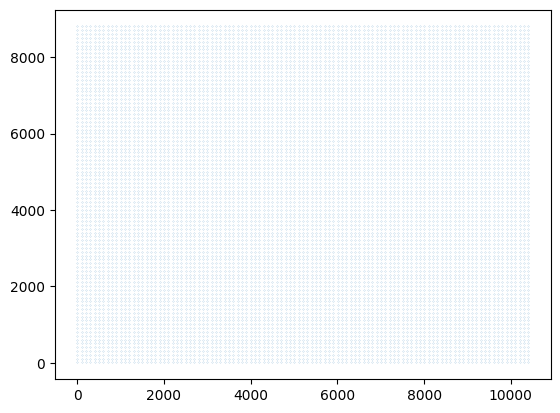

In [7]:
plt.scatter(xv, yv, s=0.01)

In [6]:
df_transcripts["spot_number"] = (np.searchsorted(x_values, df_transcripts["x_location"]) - 1) * len(y_values) + (np.searchsorted(y_values, df_transcripts["y_location"]) - 1)

In [7]:
df_transcripts.head()

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,error_prob,spot_number
0,281474976710657,191815,1,LUM,4797.2383,550.61346,15.421524,18.445875,0.014303,4188
1,281474976710663,214084,1,SEC11C,4801.7330,905.11600,14.925031,31.019386,0.000791,4191
2,281474976710672,191342,0,TCIM,4804.4920,596.05396,14.681485,22.270780,0.005928,4277
3,281474976710673,191574,0,STC1,4805.0483,414.38370,19.306356,16.183300,0.024081,4276
4,281474976710674,192193,0,STC1,4805.7170,273.81440,16.112896,26.251837,0.002370,4274


In [8]:
df_transcripts["spot_number"].describe()

count    4.377535e+07
mean     4.974483e+03
std      1.635371e+03
min      1.800000e+01
25%      3.718000e+03
50%      4.950000e+03
75%      6.188000e+03
max      9.232000e+03
Name: spot_number, dtype: float64

# Create expression counts for each spot.

In [9]:
counts = df_transcripts.groupby(['spot_number', 'feature_name']).size().reset_index(name='count')
print(counts.head())
counts["normalized_log1p_count"] = np.log1p(counts['count'])

   spot_number feature_name  count
0           18        ACTA2      1
1           18         CD8A      1
2           18         CD93      1
3           18          DSP      1
4           18         ENAH      1


In [10]:
counts_pivot = counts.pivot_table(index='spot_number', 
                                  columns='feature_name', 
                                  values='normalized_log1p_count', 
                                  fill_value=0)

In [17]:
location_means = df_transcripts.groupby('spot_number').agg({
    'x_location': 'mean',
    'y_location': 'mean',
    'z_location': 'mean'
}).reset_index()

In [30]:
breast_spots_df = location_means.join(counts_pivot, on='spot_number')

In [31]:
gene_expressions = breast_spots_df.iloc[:,4:]
print(gene_expressions.shape)
gene_expressions.head()

(7313, 541)


,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AIF1,AKR1C1,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [32]:
f"The expressions in spots have a sparsity {round(np.mean(gene_expressions == 0), 4)}"

'The expressions in spots have a sparsity 0.6292'

# Clustering w/ Location Information

### Convert to adata.

In [39]:
breast_spots_df.to_csv(f"data/hBreast/hBreastST_SPOTSIZE={SPOT_SIZE}um.csv")

In [40]:
breast_spots_adata = ad.read_csv(f"data/hBreast/hBreastST_SPOTSIZE={SPOT_SIZE}um.csv")

In [41]:
sc.tl.pca(breast_spots_adata, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(breast_spots_adata, log=True)

In [42]:
sc.pp.neighbors(breast_spots_adata, n_neighbors=15, n_pcs=20)

In [43]:
sc.tl.leiden(breast_spots_adata, resolution=1.8, key_added='leiden_1_8')
sc.tl.leiden(breast_spots_adata, resolution=1.4, key_added='leiden_1_4')
sc.tl.leiden(breast_spots_adata, resolution=2.2, key_added='leiden_2_2')
sc.tl.leiden(breast_spots_adata, resolution=1.0, key_added='leiden_1_0')
sc.tl.leiden(breast_spots_adata, resolution=0.8, key_added='leiden_0_8')
sc.tl.leiden(breast_spots_adata, resolution=0.6, key_added='leiden_0_6')
sc.tl.leiden(breast_spots_adata, resolution=0.025, key_added='leiden_0_025')
sc.tl.leiden(breast_spots_adata, resolution=0.001, key_added='leiden_0_001')

In [44]:
sc.tl.umap(breast_spots_adata, min_dist=0.1)

In [46]:
sc.pl.umap(breast_spots_adata,size=30,color='leiden_2_2',legend_loc='on data',legend_fontsize=3,legend_fontoutline=1,show=False,palette="rainbow")

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden_2_2'}, xlabel='UMAP1', ylabel='UMAP2'>

# Clustering w/o Location Information

### Convert to adata.

In [48]:
gene_expressions.to_csv(f"data/hBreast/hBreastST_SPOTSIZE={SPOT_SIZE}um_expOnly.csv")

In [49]:
gene_expressions = ad.read_csv(f"data/hBreast/hBreastST_SPOTSIZE={SPOT_SIZE}um_expOnly.csv")

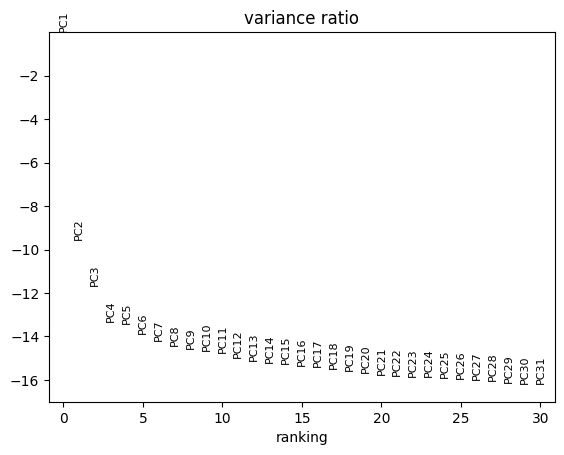

In [50]:
sc.tl.pca(gene_expressions, svd_solver='arpack')
plt.rcParams['figure.facecolor'] = 'white'
sc.pl.pca_variance_ratio(gene_expressions, log=True)

In [51]:
sc.pp.neighbors(gene_expressions, n_neighbors=15, n_pcs=20)

In [52]:
sc.tl.leiden(gene_expressions, resolution=1.8, key_added='leiden_1_8')
sc.tl.leiden(gene_expressions, resolution=1.4, key_added='leiden_1_4')
sc.tl.leiden(gene_expressions, resolution=2.2, key_added='leiden_2_2')
sc.tl.leiden(gene_expressions, resolution=1.0, key_added='leiden_1_0')
sc.tl.leiden(gene_expressions, resolution=0.8, key_added='leiden_0_8')
sc.tl.leiden(gene_expressions, resolution=0.6, key_added='leiden_0_6')
sc.tl.leiden(gene_expressions, resolution=0.025, key_added='leiden_0_025')
sc.tl.leiden(gene_expressions, resolution=0.001, key_added='leiden_0_001')

In [53]:
sc.tl.umap(gene_expressions, min_dist=0.1)

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden_0_6'}, xlabel='UMAP1', ylabel='UMAP2'>

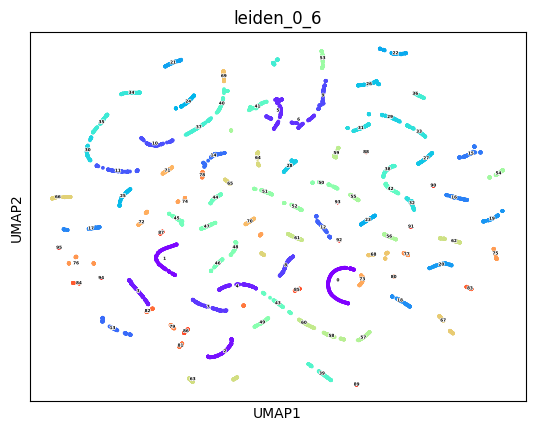

In [57]:
sc.pl.umap(gene_expressions,size=30,color='leiden_0_6',legend_loc='on data',legend_fontsize=3,legend_fontoutline=1,show=False,palette="rainbow")